<a href="https://colab.research.google.com/github/Tuan-Lee-23/Vietnamese-Reactionary-Article-Classification-/blob/main/data/preprocessed/Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/gdrive')

Mounted at /gdrive


# Clone github repo

In [3]:
# Clone the entire repo.
!git clone https://github.com/Tuan-Lee-23/Vietnamese-Reactionary-Article-Classification-.git
%cd Vietnamese-Reactionary-Article-Classification-/
!ls

fatal: destination path 'Vietnamese-Reactionary-Article-Classification-' already exists and is not an empty directory.
/content/Vietnamese-Reactionary-Article-Classification-
analysis  data	demo  modeling	README.md


# Import Libs

In [4]:
!pip install vinorm

import re
import seaborn as sns
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm
import pickle
from vinorm import TTSnorm

tqdm.pandas()

plt.rcParams["figure.figsize"] = (15,5)

     |████████████████████████████████| 40.4MB 100kB/s 


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Import data from GDRIVE

In [5]:
%cd data/datasets/
!ls

/content/Vietnamese-Reactionary-Article-Classification-/data/datasets
0  1  README.md


In [6]:
dataset_1 = os.listdir(os.getcwd() + '/1/')
dataset_0 = os.listdir(os.getcwd() + '/0/')

print(dataset_1)
print(dataset_0)


['KhoaLuatTapChi_VNCH.csv', 'haudue_vnch.csv', 'sbtn.csv', 'viettan_org.csv', 'chantroimoi_media.csv', 'KhoaLuatTapChi_ChinhTri.csv', 'PhamMinhVuFBd.csv', 'rfa.csv', 'viettan_fb.csv', 'KhoaLuatTapChi_XaHoi.csv', 'khoi8406.csv', 'viettan_org_2.csv', 'GiaoChucChuVanAn.csv', 'bpsos.csv', 'viettan_org_4.csv', 'viettan_org_3.csv', 'thanhnienconggiao.csv']
['vnexpress-chinhtri_2.csv', 'tinnoichinh.csv', 'vnexpress-chinhtri.csv']


# Preprocessing

- Clean html
- Normalize unicode
- Drop missing values
- Remove short posts
- Remove hyperlinks
- Replace abbreviation
- Check chính tả
- Keep number, special character, punctuation since BERT can handle all of them

In [ ]:
def preprocessing(df, name, len_limit = 200):

    # Clean html
    def clean_html(raw_html):
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', raw_html)
        return cleantext

    # Normalize unicode
    def normalize_unicode(txt):
        def loaddicchar():
            dic = {}
            char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
                '|')
            charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
                '|')
            for i in range(len(char1252)):
                dic[char1252[i]] = charutf8[i]
            return dic

        def convert_unicode(txt):
            dicchar = loaddicchar()
            return re.sub(
                r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
                lambda x: dicchar[x.group()], txt)
        return convert_unicode(txt)

    # Remove hyperlinks in text
    def remove_urls(input_text):
        return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

    # Save dataframe to pickle file
    def save_preprocess(df, name):
        file_name = name + '.pickle'
        pickling_on = open(file_name,"wb")
        pickle.dump(df, pickling_on)
        pickling_on.close()



## Drop missing values

In [ ]:
dataset_1 = []
for filename in os.listdir(os.getcwd() + '/1/'):
    df = pd.read_csv(os.getcwd() + '/1/' + filename)
    # df.isnull().sum()

    df = df.drop(['Unnamed: 0'], axis = 1)
    df = df.dropna()
    if 'blue' in df.columns:
        df.rename(columns = {'blue': 'content'}, inplace = True)
    dataset_1.append(df)

## Remove short posts

In [ ]:
df = dataset_1[1] 
df['avg_length'] = df['content'].apply(len)

print(df.head())

                                             content  avg_length
0  Bộ máy tuyên giáo CSVN luôn tuyên truyền về va...         576
1  BẮC KINH BỊ CÁO BUỘC DIỆT CHỦNG NGƯỜI NGÔ DUY ...         701
2  Sự bất công của ngành công an đang được bộc lộ...         335
3  5 NGƯỜI BỊ BẮT VÌ ĐƯA 200 NGƯỜI TRUNG QUỐC XUẤ...         703
4  BẦU CỬ NHƯ VIỆC NẤU ĂN\nLs Luân Lê\n\nKhi sự s...         706


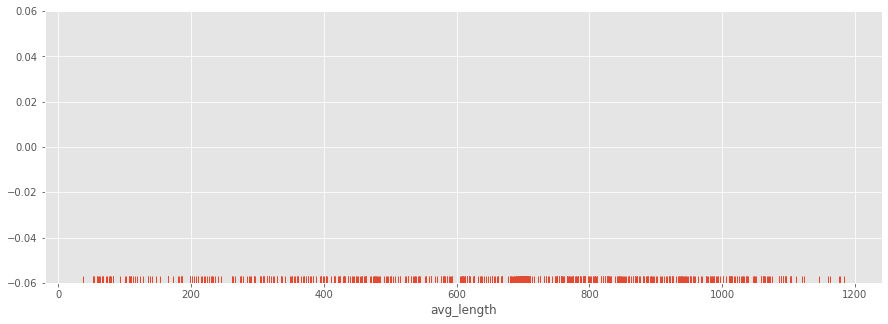

In [ ]:
plt.style.use('ggplot')
sns.rugplot(df['avg_length'])

In [ ]:
df = df[df['avg_length'] > 250]
print(df.head())
print(df.shape)

                                             content  avg_length
0  Bộ máy tuyên giáo CSVN luôn tuyên truyền về va...         576
1  BẮC KINH BỊ CÁO BUỘC DIỆT CHỦNG NGƯỜI NGÔ DUY ...         701
2  Sự bất công của ngành công an đang được bộc lộ...         335
3  5 NGƯỜI BỊ BẮT VÌ ĐƯA 200 NGƯỜI TRUNG QUỐC XUẤ...         703
4  BẦU CỬ NHƯ VIỆC NẤU ĂN\nLs Luân Lê\n\nKhi sự s...         706
(1600, 2)


## Remove links

In [ ]:
def remove_urls(input_text):
    return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)

df['content'] = df['content'].apply(remove_urls)
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,content,avg_length
0,Bộ máy tuyên giáo CSVN luôn tuyên truyền về va...,576
1,BẮC KINH BỊ CÁO BUỘC DIỆT CHỦNG NGƯỜI NGÔ DUY ...,701
2,Sự bất công của ngành công an đang được bộc lộ...,335
3,5 NGƯỜI BỊ BẮT VÌ ĐƯA 200 NGƯỜI TRUNG QUỐC XUẤ...,703
4,BẦU CỬ NHƯ VIỆC NẤU ĂN\nLs Luân Lê\n\nKhi sự s...,706


## Normalize text

In [ ]:
df['content'] = df['content'].progress_apply(lambda x: TTSnorm(x, lower = False, punc = True))

KeyboardInterrupt: ignored

['1', '0', 'VietnameseTextNormalizer', 'Makefile', 'spell.h5']
